Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/classification/auto-ml-classification.png)

# Automated Machine Learning
_**Classification with Local Compute**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Results](#Results)
1. [Test](#Test)



## Introduction

In this example we use the scikit-learn's [digit dataset](http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) to showcase how you can use AutoML for a simple classification problem.

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

In this notebook you will learn how to:
1. Create an `Experiment` in an existing `Workspace`.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using local compute.
4. Explore the results.
5. Test the best fitted model.

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

Accessing the Azure ML workspace requires authentication with Azure.

The default authentication is interactive authentication using the default tenant.  Executing the `ws = Workspace.from_config()` line in the cell below will prompt for authentication the first time that it is run.

If you have multiple Azure tenants, you can specify the tenant by replacing the `ws = Workspace.from_config()` line in the cell below with the following:

```
from azureml.core.authentication import InteractiveLoginAuthentication
auth = InteractiveLoginAuthentication(tenant_id = 'mytenantid')
ws = Workspace.from_config(auth = auth)
```

If you need to run in an environment where interactive login is not possible, you can use Service Principal authentication by replacing the `ws = Workspace.from_config()` line in the cell below with the following:

```
from azureml.core.authentication import ServicePrincipalAuthentication
auth = auth = ServicePrincipalAuthentication('mytenantid', 'myappid', 'mypassword')
ws = Workspace.from_config(auth = auth)
```
For more details, see [aka.ms/aml-notebook-auth](http://aka.ms/aml-notebook-auth)

In [2]:
ws = Workspace.from_config()

# Choose a name for the experiment.
experiment_name = 'automl-classification'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.3.0
Subscription ID,381b38e9-9840-4719-a5a0-61d9585e1e91
Workspace Name,cesardl-automl-ncentralus-demo-ws
Resource Group,cesardl-automl-ncentralus-demo-ws-resgrp
Location,northcentralus
Experiment Name,automl-classification


## Data

This uses scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.

In [3]:
digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

## Train

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**featurization**| 'auto' / 'off' / FeaturizationConfig Indicator for whether featurization step should be done automatically or not, or whether customized featurization should be used. Note: If the input data is sparse, featurization cannot be turned on.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], Multi-class targets.|
|**n_cross_validations**|Number of cross validation splits.|

Automated machine learning trains multiple machine learning pipelines.  Each pipelines training is known as an iteration.
* You can specify a maximum number of iterations using the `iterations` parameter.
* You can specify a maximum time for the run using the `experiment_timeout_hours` parameter.
* If you specify neither the `iterations` nor the `experiment_timeout_hours`, automated ML keeps running iterations while it continues to see improvements in the scores.

The following example doesn't specify `iterations` or `experiment_timeout_hours` and so runs until the scores stop improving.


In [4]:
automl_config = AutoMLConfig(task = 'classification',
                             primary_metric = 'AUC_weighted',
                             featurization = 'off',
                             X = X_train, 
                             y = y_train,
                             n_cross_validations = 3)

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

In [5]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883

Current status: DatasetCrossValidationSplit. Generating CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Classes are balanced in the training data.

****************************************************************************************************
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*****************************************************************************************

In [7]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification,AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


Optionally, you can continue an interrupted local run by calling `continue_experiment` without the `iterations` parameter, or run more iterations for a completed run by specifying the `iterations` parameter:

In [ ]:
local_run = local_run.continue_experiment(X = X_train, 
                                          y = y_train, 
                                          show_output = True,
                                          iterations = 5)

## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [8]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…


#### Retrieve All Child Runs
You can also use SDK methods to fetch all the child runs and see individual metrics that we log.

In [9]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
AUC_macro,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00,1.00,...,1.00,1.00,1.00,0.84,1.00,1.00,1.00,1.00,1.00,0.98
AUC_micro,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00,1.00,...,1.00,1.00,1.00,0.79,1.00,1.00,1.00,1.00,1.00,0.98
AUC_weighted,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00,1.00,...,1.00,1.00,1.00,0.84,1.00,1.00,1.00,1.00,1.00,0.98
accuracy,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.94,0.94,0.94,...,0.96,0.95,0.94,0.40,0.97,0.94,0.96,0.95,0.99,0.77
average_precision_score_macro,0.99,0.99,0.98,0.99,0.98,0.99,0.94,0.98,0.98,0.98,...,0.99,0.99,0.98,0.61,1.00,0.98,0.99,0.99,1.00,0.96
average_precision_score_micro,0.99,0.99,0.98,0.99,0.98,0.99,0.94,0.98,0.98,0.98,...,0.99,0.99,0.99,0.45,1.00,0.98,0.99,0.99,1.00,0.91
average_precision_score_weighted,0.99,0.99,0.98,0.99,0.98,0.99,0.94,0.98,0.98,0.98,...,0.99,0.99,0.98,0.61,1.00,0.98,0.99,0.99,1.00,0.96
balanced_accuracy,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.94,0.94,0.94,...,0.96,0.95,0.94,0.39,0.97,0.94,0.96,0.95,0.99,0.78
f1_score_macro,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.94,0.94,0.94,...,0.96,0.95,0.94,0.38,0.97,0.94,0.96,0.95,0.99,0.74
f1_score_micro,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.94,0.94,0.94,...,0.96,0.95,0.94,0.40,0.97,0.94,0.96,0.95,0.99,0.77


### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [10]:
best_run, fitted_model = local_run.get_output()
print(best_run)

Run(Experiment: automl-classification,
Id: AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_45,
Type: None,
Status: Completed)


#### Print the properties of the model
The fitted_model is a python object and you can read the different properties of the object.
The following shows printing hyperparameters for each step in the pipeline.

In [11]:
from pprint import pprint

def print_model(model, prefix=""):
    for step in model.steps:
        print(prefix + step[0])
        if hasattr(step[1], 'estimators') and hasattr(step[1], 'weights'):
            pprint({'estimators': list(e[0] for e in step[1].estimators), 'weights': step[1].weights})
            print()
            for estimator in step[1].estimators:
                print_model(estimator[1], estimator[0]+ ' - ')
        elif hasattr(step[1], '_base_learners') and hasattr(step[1], '_meta_learner'):
            print("\nMeta Learner")
            pprint(step[1]._meta_learner)
            print()
            for estimator in step[1]._base_learners:
                print_model(estimator[1], estimator[0]+ ' - ')
        else:
            pprint(step[1].get_params())
            print()
            
print_model(fitted_model)

prefittedsoftvotingclassifier
{'estimators': ['34', '41', '26', '27', '0', '1', '17', '35'],
 'weights': [0.4666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.13333333333333333]}

34 - StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': False,
 'with_std': True}

34 - SVCWrapper
{'C': 4714.8663634573895,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

41 - StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': False,
 'with_std

#### Best Model Based on Any Other Metric
Show the run and the model that has the smallest `log_loss` value:

In [12]:
lookup_metric = "log_loss"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print(best_run)

Run(Experiment: automl-classification,
Id: AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_41,
Type: None,
Status: Completed)


In [13]:
print_model(fitted_model)

StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': False,
 'with_std': False}

XGBoostClassifier
{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6,
 'eta': 0.4,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 8,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 400,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1.6666666666666667,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.8,
 'tree_method': 'auto',
 'verbose': -10,
 'verbosity': 1}



#### Model from a Specific Iteration
Show the run and the model from the third iteration:

In [14]:
iteration = 3
third_run, third_model = local_run.get_output(iteration = iteration)
print(third_run)

Run(Experiment: automl-classification,
Id: AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_3,
Type: None,
Status: Completed)


In [15]:
print_model(third_model)

StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': True,
 'with_std': True}

SGDClassifierWrapper
{'alpha': 1.4286571428571428,
 'class_weight': None,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.7551020408163265,
 'learning_rate': 'constant',
 'loss': 'log',
 'max_iter': 1000,
 'n_jobs': 1,
 'penalty': 'none',
 'power_t': 0.4444444444444444,
 'random_state': None,
 'tol': 0.001}



## Test 

#### Load Test Data

In [16]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

#### Testing Our Best Fitted Model
We will try to predict 2 digits and see how our model works.

4


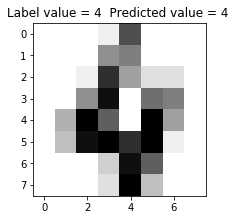

0


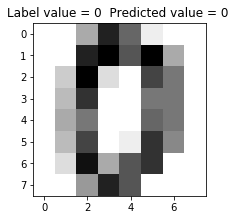

In [17]:
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

### Show model definition from existing run in Azure ML runs history

In [33]:
from azureml.train.automl.run import AutoMLRun

ws = Workspace.from_config()
experiment = ws.experiments['automl-classification']
automl_run = AutoMLRun(experiment, run_id = 'AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883')

automl_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification,AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [35]:
best_run, model_from_aml = automl_run.get_output()

print_model(model_from_aml)

prefittedsoftvotingclassifier
{'estimators': ['34', '41', '26', '27', '0', '1', '17', '35'],
 'weights': [0.4666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.13333333333333333]}

34 - StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': False,
 'with_std': True}

34 - SVCWrapper
{'C': 4714.8663634573895,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

41 - StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': False,
 'with_std

In [29]:
# List runs


run = next(run for run in experiment.get_runs() if run.id == 'AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883')

for r in run.get_children():
    print(r.name)
#    if r.name == 'AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_45':
#        automl_run = r
        
# automl_run

AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_46
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_45
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_44
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_43
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_42
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_41
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_40
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_39
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_38
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_37
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_36
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_35
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_34
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_33
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_32
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_31
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_30
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_29
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_28
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_27
AutoML_9fe201fe-89fd-41cc-905f-2f41a5a98883_26
AutoML_9fe201